This notebook will demonstrate the functions that are used to calculate the quantitative evaluation metric for each magnification in the data set. The quantitative evaluation metric used to assess the hackathon contributions is divided into two parts: The images are compared using the mean absolute error (MAE) between generated and ground truth images using 1) features extracted by the CellProfiler and 2) pixel values.

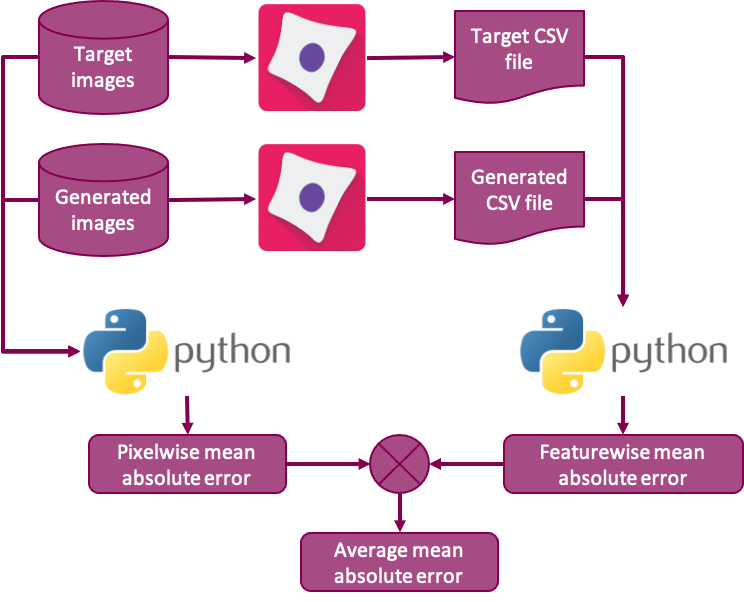

These are averaged to yield the final metric value. The evaluation suite in the provided notebook will be run on each magnification seperately and the final metric is given by a weighted average as detailed in the notebook.

The image folders needs to contain image triplets with the following naming convention:

```
AssayPlate_Greiner_#655090_D02_T0001F007L01A01Z01C01.tif
AssayPlate_Greiner_#655090_D02_T0001F007L01A01Z01C02.tif
AssayPlate_Greiner_#655090_D02_T0001F007L01A01Z01C03.tif
```
representing the three target channels for each well and field of view.

IMPORTANT! To be able to compare target and generated images using the provided pipe-line, the images in the respective sets need to adhere to the same naming convention. We recommend that the generated and target images are named identically to avoid errors in the evaluation process.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../src/")

In [3]:
import os
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm
from inference import *
from eval_metrics import *
import shutil

In [4]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [5]:
PIPELINE_DIR = "../cellprofiler_pipelines/"
SLIDESET_ROOT = '../tmp/test_slides/' # including subsets 20x_input/20x_target/40x_input/40x_target, 60x_input/60x_target
MODEL_ROOT = "../models/"
ZOOM_LEVELS = ["20", "40", "60"]

## Input data

In [6]:
# Determine the data
all_tif_paths = [str(fn) for fn in Path(f"{SLIDESET_ROOT}").rglob("*.tif")]
all_tif_paths = sorted(all_tif_paths)
dataset_df = pd.DataFrame({"tif_path": all_tif_paths})
dataset_df['slide_id'] = dataset_df.tif_path.apply(lambda x: Path(x).stem.replace("AssayPlate_Greiner_#655090_", ""))
dataset_df['slide_no'] = dataset_df.slide_id.apply(lambda x: x[-4] if x[-1]=="4" 
                                                   else x[-1])
dataset_df['slide_id'] = dataset_df.slide_id.apply(lambda x: x[:-4]+"X"+x[-3:] if x[-1]=="4" else 
                                                   x[:-7]+"X"+x[-6:-4] +"X"+x[-3:-1]+"X")
dataset_df['slide_id'] = dataset_df.slide_id.apply(lambda x: x[:-7]+"X"+x[-6:-1]+"X")
dataset_df['zoom'] = dataset_df.tif_path.apply(lambda x: x.split("/")[3][:2])
dataset_df['is_target'] = dataset_df.tif_path.apply(lambda x: "target" in x)

dataset_df = dataset_df.sort_values(["zoom", "slide_no", ])
dataset_df.groupby(['zoom', 'is_target', 'slide_id']).size()

zoom  is_target  slide_id                 
20    False      B03_T0001F005L01A0XZ0XC0X    7
                 B04_T0001F004L01A0XZ0XC0X    7
                 C02_T0001F003L01A0XZ0XC0X    7
                 C03_T0001F002L01A0XZ0XC0X    7
                 C03_T0001F006L01A0XZ0XC0X    7
                                             ..
60    True       D02_T0001F010L01A0XZ0XC0X    3
                 D03_T0001F006L01A0XZ0XC0X    3
                 D03_T0001F011L01A0XZ0XC0X    3
                 D04_T0001F004L01A0XZ0XC0X    3
                 D04_T0001F009L01A0XZ0XC0X    3
Length: 80, dtype: int64

In [7]:
slide_ids = dataset_df.slide_id.unique()
print(f"Found {len(slide_ids)} unique slides")

Found 38 unique slides


## Models

In [8]:
# available model_dirs
AVAILABLE_MODEL_DIRS = set(str(fn).split("/")[2] for fn in Path(f"{MODEL_ROOT}").rglob("*model_config.json"))
AVAILABLE_MODEL_DIRS

{'20201108-212542_resnet50', '20201109-193651_resnet50'}

In [9]:
ensemble = [os.path.join(MODEL_ROOT, m) for m in AVAILABLE_MODEL_DIRS]

## Data evaluation

In [ ]:
zoom = ZOOM_LEVELS[0] #for zoom in ZOOM_LEVELS:
model_dir = ensemble[0] #for model_dir in ensemble:

for zoom in tqdm(ZOOM_LEVELS, desc="[predict] zoom level"):
    zoom_df = dataset_df.copy()[(dataset_df.zoom==zoom)]
    slide_ids = zoom_df.slide_id.unique()
    
    for slide_id in tqdm(slide_ids, desc="[predict] slides"):

        # generate paths to store the predictions
        pred_output_dir = f"../tmp/{zoom}x_preds/"
        target_output_dir = f"../tmp/{zoom}x_targets/"
        Path(pred_output_dir).mkdir(parents=True, exist_ok=True)
        Path(target_output_dir).mkdir(parents=True, exist_ok=True)

        predict_files = zoom_df[(zoom_df.slide_id == slide_id) & 
                                (~zoom_df.is_target )
                               ].tif_path.to_list()

        target_files = zoom_df[(zoom_df.slide_id == slide_id) & 
                               (zoom_df.is_target )
                              ].tif_path.to_list()

        assert len(predict_files)==7
        assert len(target_files)==3

        # Inference magic starts here
        predict(zoom=f"{zoom}", 
                model_dir=f"{model_dir}",
                predict_files=predict_files,
                output_dir=pred_output_dir,
                disable_tqdm=True
               )
        for tgt_fn in target_files:
            shutil.copyfile(tgt_fn, f"{target_output_dir}/{Path(tgt_fn).name}")

In [ ]:
# CellProfiler "magic" starts here
with HiddenPrints():
for zoom in tqdm(ZOOM_LEVELS, desc="[cellprofiler] zoom level"):

    pred_output_dir = f"../tmp/{zoom}x_preds/"
    target_output_dir = f"../tmp/{zoom}x_targets/"
    
    cp_cmd_preds = f"cellprofiler -c -r "\
             f"-p {os.path.abspath(PIPELINE_DIR)}/Adipocyte_pipeline_{zoom}x_ver3.cppipe "\
             f"-o {os.path.abspath(pred_output_dir)}/csv/ "\
             f"-i {os.path.abspath(pred_output_dir)}"
    !$cp_cmd_preds


    cp_cmd_targets = f"cellprofiler -c -r "\
             f"-p {os.path.abspath(PIPELINE_DIR)}/Adipocyte_pipeline_{zoom}x_ver3.cppipe "\
             f"-o {os.path.abspath(target_output_dir)}/csv/ "\
             f"-i {os.path.abspath(target_output_dir)}"
    !$cp_cmd_targets

In [ ]:
# Evaluation magic starts here
eval_data = []
for zoom in tqdm(ZOOM_LEVELS, desc="zoom level"):
    
    pred_output_dir = f"../tmp/{zoom}x_preds/"
    target_output_dir = f"../tmp/{zoom}x_targets/"
    pred_file = f"{os.path.abspath(pred_output_dir)}/csv/Adipocytes_Image.csv"
    targ_file = f"{os.path.abspath(target_output_dir)}/csv/Adipocytes_Image.csv"
    
    mae_cp, mae_per_feature, feature_names = get_featurewise_mean_absolute_error(targ_file, pred_file)
    mae_pix,_,_,_ = get_pixelwise_mean_absolute_error(target_output_dir, pred_output_dir)

    mae = np.average([mae_cp, mae_pix])
    print(f"Pixelwise MAE {mae_pix}")
    print(f"CP feature MAE {mae_cp}")
    print(f"Evaluation metric {mae}")
    
    eval_data.append(
        {'zoom':zoom,
         'data':
         {
             'mae_cp':mae_cp,
             'mae_per_feature':mae_per_feature,
             'mae_pix':mae_pix,
             'mae_total':mae
         }})
    

In [ ]:
# y_c01, y_c02, y_c03 = (k.astype(np.uint16) for k in convert_images_to_array(target_output_dir))
# image_index = 0 # choose image
# f, ax = plt.subplots(1, 4, sharey=False, sharex=False, figsize = (40,10)) 

# ax[0].imshow( np.clip(y_c01[image_index,:,:], 0, np.quantile(y_c01, q=0.95)) )
# ax[0].set_title('C01',size=20)
# ax[0].get_xaxis().set_visible(False)
# ax[0].get_yaxis().set_visible(False)

# ax[1].imshow( np.clip(y_c02[image_index,:,:], 0, np.quantile(y_c02, q=0.95)) )
# ax[1].set_title('C02',size=20)
# ax[1].get_xaxis().set_visible(False)
# ax[1].get_yaxis().set_visible(False)

# ax[2].imshow( np.clip(y_c03[image_index,:,:], 0, np.quantile(y_c03, q=0.95)) )
# ax[2].set_title('C03',size=20)
# ax[2].get_xaxis().set_visible(False)
# ax[2].get_yaxis().set_visible(False)

# ax[3].hist(y_c01.ravel(), bins=range(0,y_c01.max(),100), color='r', alpha=0.33, label='C01')
# ax[3].hist(y_c02.ravel(), bins=range(0,y_c02.max(),100), color='g', alpha=0.33, label='C02')
# ax[3].hist(y_c03.ravel(), bins=range(0,y_c03.max(),100), color='b', alpha=0.33, label='C03')
# ax[3].set_title('Pixel values',size=20)
# ax[3].get_xaxis().set_visible(True)
# ax[3].get_yaxis().set_visible(True)
# ax[3].set_xscale('log')
# ax[3].set_xlim([100,15e3])
# ax[3].legend(fontsize=20)

# plt.tight_layout()
# plt.suptitle("Target", fontsize=40)
# plt.show()



# y_c01, y_c02, y_c03 = (k.astype(np.uint16) for k in convert_images_to_array(pred_output_dir))
# image_index = 0 # choose image
# f, ax = plt.subplots(1, 4, sharey=False, sharex=False, figsize = (40,10)) 

# ax[0].imshow( np.clip(y_c01[image_index,:,:], 0, np.quantile(y_c01, q=0.95)) )
# ax[0].set_title('C01',size=20)
# ax[0].get_xaxis().set_visible(False)
# ax[0].get_yaxis().set_visible(False)

# ax[1].imshow( np.clip(y_c02[image_index,:,:], 0, np.quantile(y_c02, q=0.95)) )
# ax[1].set_title('C02',size=20)
# ax[1].get_xaxis().set_visible(False)
# ax[1].get_yaxis().set_visible(False)

# ax[2].imshow( np.clip(y_c03[image_index,:,:], 0, np.quantile(y_c03, q=0.95)) )
# ax[2].set_title('C03',size=20)
# ax[2].get_xaxis().set_visible(False)
# ax[2].get_yaxis().set_visible(False)

# ax[3].hist(y_c01.ravel(), bins=range(0,y_c01.max(),100), color='r', alpha=0.33, label='C01')
# ax[3].hist(y_c02.ravel(), bins=range(0,y_c02.max(),100), color='g', alpha=0.33, label='C02')
# ax[3].hist(y_c03.ravel(), bins=range(0,y_c03.max(),100), color='b', alpha=0.33, label='C03')
# ax[3].set_title('Pixel values',size=20)
# ax[3].get_xaxis().set_visible(True)
# ax[3].get_yaxis().set_visible(True)
# ax[3].set_xscale('log')
# ax[3].set_xlim([100,15e3])
# ax[3].legend(fontsize=20)

# plt.tight_layout()
# plt.suptitle("Prediction", fontsize=40)
# plt.show()